In this tutorial, we will show best practices in using PathML from start to finish in training and evaluating two kinds of models, a classification model and a segmentation model, on a subset of whole-slide images that come from the CAMELYON16 dataset. These images show breast lymph nodes, and the task is to identify slides and/or regions of the slides which contain breast cancer metastases. We have ground truth annotations for all slides from expert pathologists. Although the full dataset contains 400 WSIs, we have created a microdataset of 18 of these slides for the purposes of this tutorial: 6 training slides, 6 validation slides, and 6 testing slides, each with 3 metastasis-containing/tumor slides and 3 negative slides.

First, we must import the libraries we need to run this tutorial. Please change the pathml and pathml-tutorial paths to your installation paths (indicated below with comments). PathML can be downloaded from here: https://github.com/markowetzlab/pathml

NOTE: If during the PathML import below, an error occurs with a message referencing something from libvips being missing, this is an issue with installing pyvips via pip. To solve this issue, run the following command inside your pathml-env conda environment to install the conda distribution of pyvips:

```conda install -c conda-forge pyvips```

In [1]:
import glob
import os
import pickle
import sys
from pathlib import Path
import random
from tqdm import tqdm

# change these to your local paths
sys.path.append('/home/cri.camres.org/berman01/Documents/pathml') # not necessary if you install PathML with pip
#sys.path.append('/path/to/pathml-tutorial/Pytorch-UNet')

from pathml.slide import Slide

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import albumentations as A
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
import time
#import logging

#from unet import UNet
#from eval import eval_net
#from utils.dataset import PathmlSegmentationDataset, visualizeSegmentationAugmentation
#from torch.utils.data import DataLoader, random_split
#from dice_loss import dice_coeff

Let's define some constants and paths and make some directories we'll need. Make a wsi_data directory and populate it with the WSIs named below. These WSIs can be found in the tumor and normal folders at the follwing link: [[]]

Make sure to change the path to the analysis directory (analysis_dir_path) to the directory where you will be working on your machine (same with the the path to wsi_data)!

In [33]:
# change to your local paths
analysis_dir_path = '/media/berman01/Expansion/benchmark_deep_tissue_detector'
wsi_path = '/media/berman01/Expansion/benchmark_deep_tissue_detector/wsis'

pathml_slide_dir_path = os.path.join(analysis_dir_path, 'pathml_slides')
annotations_dir_path = os.path.join(analysis_dir_path, 'annotations')

os.makedirs(analysis_dir_path, exist_ok=True)
os.makedirs(pathml_slide_dir_path, exist_ok=True)
os.makedirs(annotations_dir_path, exist_ok=True)
os.makedirs(os.path.join(analysis_dir_path, 'results'), exist_ok=True)

tcga_tgct_cases = ['TCGA-2G-AAGK-01Z-00-DX1.D0530A91-8CA1-47AA-95AF-AB7B901DC5B6', 
         'TCGA-2G-AAHN-01Z-00-DX1.B5CCB104-C436-4B80-8F47-EB9C7D13ACF0', 
         'TCGA-2G-AAKD-01Z-00-DX1.137A7B81-38C0-4715-BF9A-64BDB219DB9A', 
         'TCGA-2G-AAKO-05Z-00-DX1.2668F339-535C-4981-ADF7-9B47C15ED272', 
         'TCGA-YU-A94D-01Z-00-DX1.9B1832C3-F7CA-410A-AC74-28FCB282D05D']
camelyon_cases = ['normal_004']
cases = tcga_tgct_cases + camelyon_cases
wsi_paths = [os.path.join(wsi_path, case+'.svs') for case in tcga_tgct_cases]+[os.path.join(wsi_path, case+'.tif') for case in camelyon_cases] 
print(wsi_paths)


['/media/berman01/Expansion/benchmark_deep_tissue_detector/wsis/TCGA-2G-AAGK-01Z-00-DX1.D0530A91-8CA1-47AA-95AF-AB7B901DC5B6.svs', '/media/berman01/Expansion/benchmark_deep_tissue_detector/wsis/TCGA-2G-AAHN-01Z-00-DX1.B5CCB104-C436-4B80-8F47-EB9C7D13ACF0.svs', '/media/berman01/Expansion/benchmark_deep_tissue_detector/wsis/TCGA-2G-AAKD-01Z-00-DX1.137A7B81-38C0-4715-BF9A-64BDB219DB9A.svs', '/media/berman01/Expansion/benchmark_deep_tissue_detector/wsis/TCGA-2G-AAKO-05Z-00-DX1.2668F339-535C-4981-ADF7-9B47C15ED272.svs', '/media/berman01/Expansion/benchmark_deep_tissue_detector/wsis/TCGA-YU-A94D-01Z-00-DX1.9B1832C3-F7CA-410A-AC74-28FCB282D05D.svs', '/media/berman01/Expansion/benchmark_deep_tissue_detector/wsis/normal_004.tif']


First we'll define a pathml Slide object for each whole-slide image (WSI). We can use PathML to break the image up into tiles of the desired size and separate all tiles showing background and artifact from those showing actual tissue. We can then add annotations for our ground truth tissue regions. When adding annotations, make sure to set the name of the class for "donut hole" or negative regions to extract from other annotations with the negativeClass argument of Slide.addAnnotations().

NOTE: Some users may find that progress freezes as the first WSI is being run through Slide.detectTissue(). This is a PyTorch issue. If this happens to you, set numWorkers=0 in the Slide.detectTissue() call, and tissue detection should proceed (albeit slowly). The default of numWorkers in Slide.detectTissue() is 16. (2m 31s)

In [38]:
start_time = time.time()

tile_size = 500 # pixels

for wsi_path in ['/media/berman01/Expansion/benchmark_deep_tissue_detector/wsis/normal_004.tif']:#wsi_paths:
    case = Path(wsi_path).stem
    pathml_slide = Slide(wsi_path, level=0).setTileProperties(tileSize=tile_size)
    
    annotation_path = os.path.join(analysis_dir_path, 'annotations', case+'.xml')
    print(annotation_path)
    pathml_slide.addAnnotations(annotation_path, negativeClass='negative')
    
    if case in camelyon_cases:
        pathml_slide.detectForeground(level=4)
    elif case in tcga_tgct_cases:
        pathml_slide.detectForeground(level=2)
    
    pathml_slide.detectTissue() 
    

    
    pathml_slide.save(folder=pathml_slide_dir_path)
    
time_elapsed = time.time() - start_time
print('Complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

/media/berman01/Expansion/benchmark_deep_tissue_detector/annotations/normal_004.xml
Scale: 1.0
xml file valid - 39 annotation(s) found.
Inferring tissue detection model using GPU
Detecting tissue of /media/berman01/Expansion/benchmark_deep_tissue_detector/wsis/normal_004.tif


100%|██████████| 1002/1002 [01:22<00:00, 12.13it/s]


Complete in 2m 8s


Let's check to make sure the tissue detector is filtering the tiles we want and compare the results to Otsu's method and the triangle algorithm on our six validation slides: (48s)

/home/cri.camres.org/berman01/Documents/pathml/pathml/slide.py:2184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


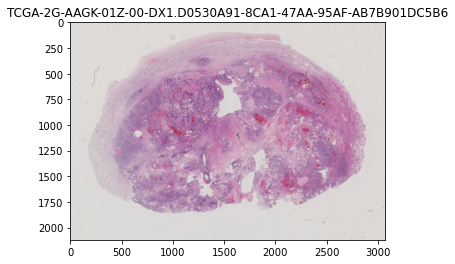

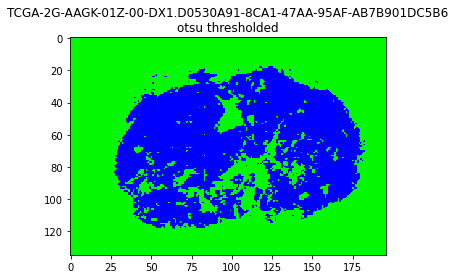

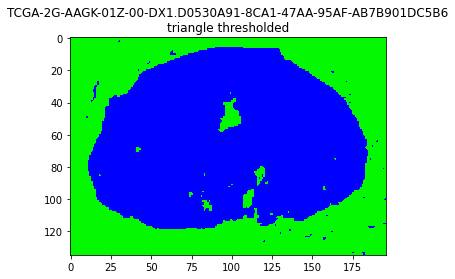

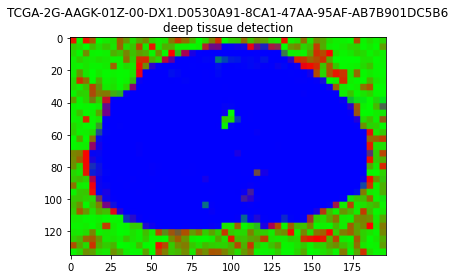

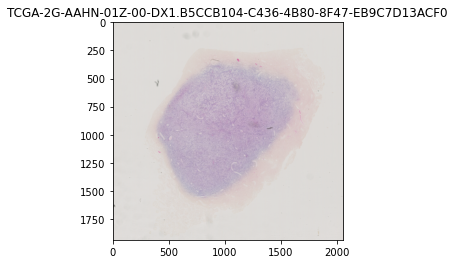

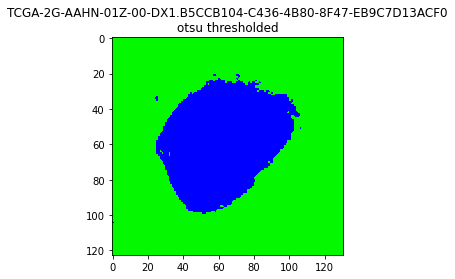

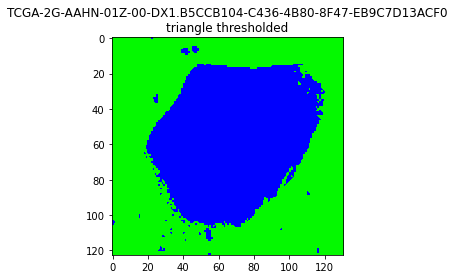

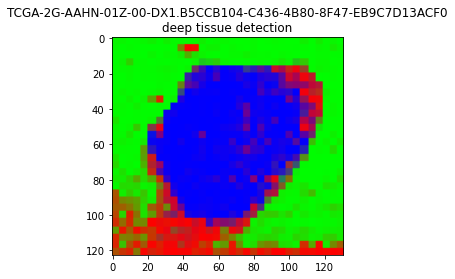

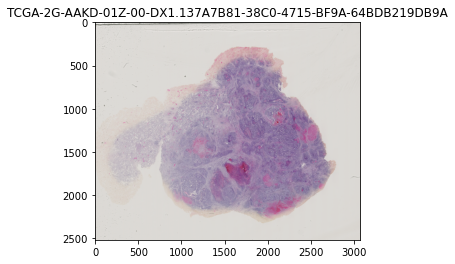

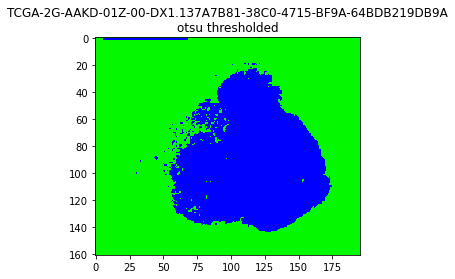

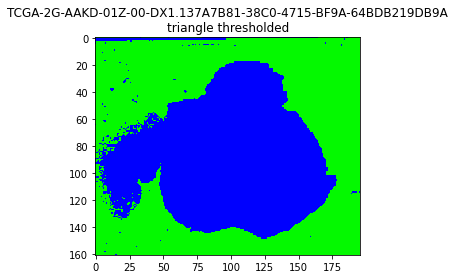

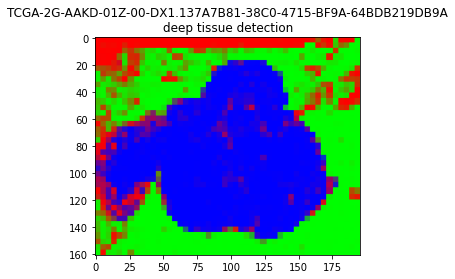

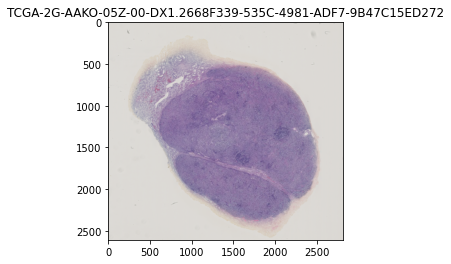

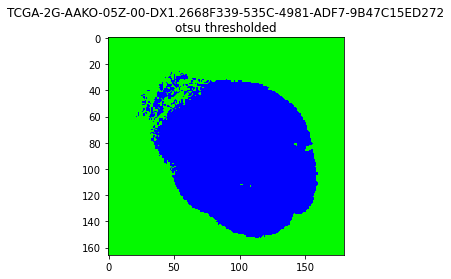

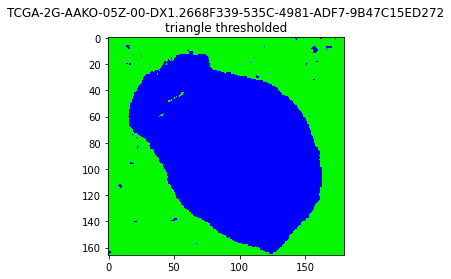

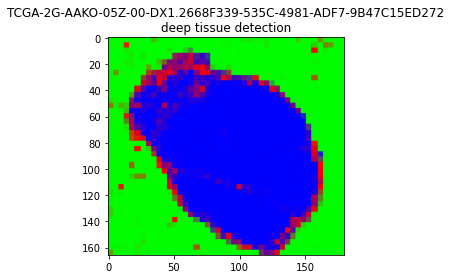

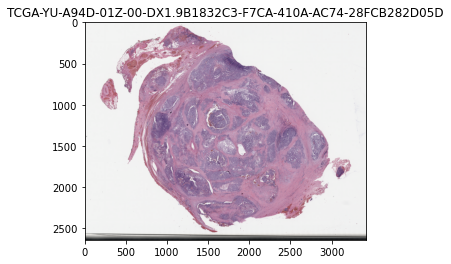

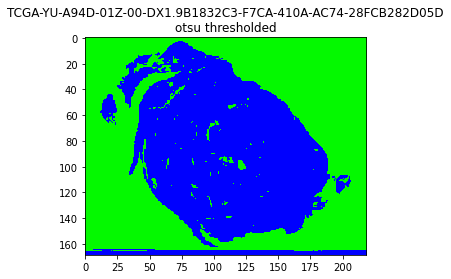

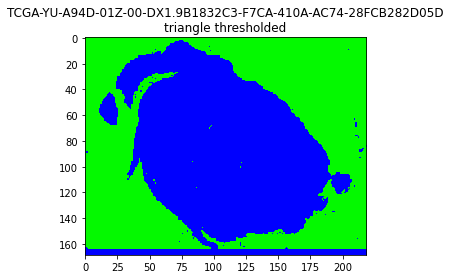

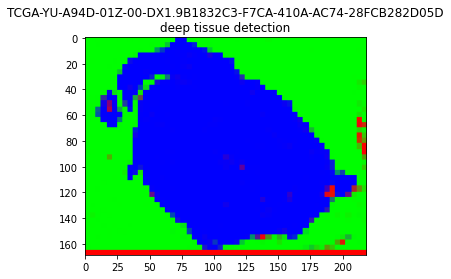

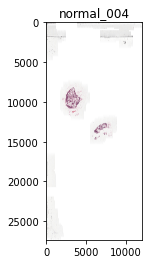

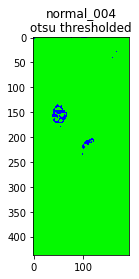

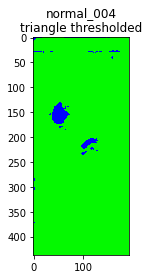

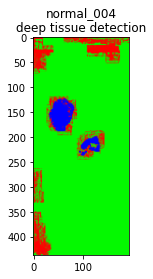

In [39]:
for case in cases:
    pathml_slide = Slide(os.path.join(analysis_dir_path, 'pathml_slides', case+'.pml'))
    pathml_slide.visualizeThumbnail(folder=os.path.join(analysis_dir_path, 'results'), level=3)
    pathml_slide.visualizeForeground('otsu', folder=os.path.join(analysis_dir_path, 'results'))
    pathml_slide.visualizeForeground('triangle', folder=os.path.join(analysis_dir_path, 'results'))
    pathml_slide.visualizeTissueDetection(folder=os.path.join(analysis_dir_path, 'results'))

We see that in addition to not having any artifact detection capabilities, Otsu's method excludes lighter-colored tissue from the central region of the upper tissue section, whereas the triangle method erroniously includes dark slide artifact regions around the edge of the slide to be tissue. The deep tissue detector seems to be performing well, and we can verify this by checking all of the deep tissue detector class map images we generated alongside all of our trainval slides in the same directory we stored our PathML slides.

Now we can iterate over all tiles in the WSIs to compare the Otsu, triangle, and deep tissue detector results for identifying tissue regions with the annotated ground truth

In [40]:
start_time = time.time()

ground_truth_tissue_overlaps_all_slides = {}
otsu_classifications_all_slides = {}
triangle_classifications_all_slides = {}
dtd_tissue_probs_all_slides = {}
dtd_artifact_probs_all_slides = {}
dtd_background_probs_all_slides = {}

for case in cases:
    ground_truth_tissue_overlaps = []
    otsu_classifications = []
    triangle_classifications = []
    dtd_tissue_probs = []
    dtd_artifact_probs = []
    dtd_background_probs = []
    
    pathml_slide = Slide(os.path.join(analysis_dir_path, 'pathml_slides', case+'.pml'))

    for tile_coords in pathml_slide.iterateTiles():
        tile_data = pathml_slide.tileDictionary[tile_coords]

        ground_truth_tissue_overlaps.append(tile_data['tissueOverlap'])
        otsu_classifications.append(tile_data['foregroundOtsu'])
        triangle_classifications.append(tile_data['foregroundTriangle'])
        dtd_tissue_probs.append(tile_data['tissueLevel'])
        dtd_artifact_probs.append(tile_data['artifactLevel'])
        dtd_background_probs.append(tile_data['backgroundLevel'])
    
    ground_truth_tissue_overlaps_all_slides[case] = ground_truth_tissue_overlaps
    otsu_classifications_all_slides[case] = otsu_classifications
    triangle_classifications_all_slides[case] = triangle_classifications
    dtd_tissue_probs_all_slides[case] = dtd_tissue_probs
    dtd_artifact_probs_all_slides[case] = dtd_artifact_probs
    dtd_background_probs_all_slides[case] = dtd_background_probs
        
        
time_elapsed = time.time() - start_time
print('Complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Complete in 0m 1s


Next let's use these data to calculate the accuracy of each tissue detection method (Otsu, triangle, deep tissue detector) for each slide

In [41]:
#print('GROUND TRUTH')
#print(ground_truth_tissue_overlaps_all_slides['TCGA-2G-AAGK-01Z-00-DX1.D0530A91-8CA1-47AA-95AF-AB7B901DC5B6'])
#print('DEEP TISSUE DETECTOR')
#print(dtd_tissue_probs_all_slides['TCGA-2G-AAGK-01Z-00-DX1.D0530A91-8CA1-47AA-95AF-AB7B901DC5B6'])

# sensitivity to tissue class

for case in cases:
    ground_truth = [i > 0.9 for i in ground_truth_tissue_overlaps_all_slides[case]]
    deep_tissue_detector = [i > 0.3 for i in dtd_tissue_probs_all_slides[case]]
    #print(deep_tissue_detector)
    otsu = otsu_classifications_all_slides[case]
    triangle = triangle_classifications_all_slides[case]
    
    print('deep tissue detector accuracy')
    print(sum(1 for x,y in zip(ground_truth, deep_tissue_detector) if x == y) / len(ground_truth))
    print('otsu accuracy')
    print(sum(1 for x,y in zip(ground_truth, otsu) if x == y) / len(ground_truth))
    print('triangle accuracy')
    print(sum(1 for x,y in zip(ground_truth, triangle) if x == y) / len(ground_truth))

    


deep tissue detector accuracy
0.9401360544217687
otsu accuracy
0.8258503401360544
triangle accuracy
0.9697656840513983
deep tissue detector accuracy
0.9319183268168559
otsu accuracy
0.8228138769937318
triangle accuracy
0.9630112331657668
deep tissue detector accuracy
0.9619406768918748
otsu accuracy
0.8414881480542528
triangle accuracy
0.9628913677272151
deep tissue detector accuracy
0.9607095046854083
otsu accuracy
0.8998326639892905
triangle accuracy
0.9841700133868808
deep tissue detector accuracy
0.933668368863311
otsu accuracy
0.9528788738483154
triangle accuracy
0.9429899219151063
deep tissue detector accuracy
0.9761632341723875
otsu accuracy
0.9921696224256293
triangle accuracy
0.98806969870328


Next let's compute the mean and standard deviation of our tile dataset from the statistics we collected during tile extraction so that we can normalize to it during training.

In [19]:
total_pixels_per_channel = global_tile_count * tile_size * tile_size
global_channel_means = np.divide(global_channel_sums, total_pixels_per_channel)
global_channel_squared_means = np.divide(global_channel_squared_sums, total_pixels_per_channel)
global_channel_variances = np.subtract(global_channel_squared_means, np.square(global_channel_means))
global_channel_stds = np.sqrt(global_channel_variances * (total_pixels_per_channel / (total_pixels_per_channel-1)))
means_and_stds = {'channel_means': global_channel_means.tolist(), 'channel_stds': global_channel_stds.tolist()}
pickle.dump(means_and_stds,
    open(os.path.join(analysis_dir_path, 'classification_results', 'trainval_channel_means_and_stds.p'), 'wb'))

print('Channel means:', global_channel_means.tolist())
print('Channel standard deviations:', global_channel_stds.tolist())

Channel means: [0.7108909959583334, 0.5358946373919271, 0.67271422146875]
Channel standard deviations: [0.2181926132432773, 0.2555979509443369, 0.19596493031392345]


Evaluate whether our class sizes are balanced and whether an imbalanced dataset sampler is needed.

In [18]:
metastasis_tiles = glob.glob(os.path.join(analysis_dir_path, 'tiles', '*', 'metastasis', '*.jpg'))
non_metastasis_tiles = glob.glob(os.path.join(analysis_dir_path, 'tiles', '*', 'non_metastasis', '*.jpg'))
print('Total number of metastasis tiles:', len(metastasis_tiles))
print('Total number of non-metastasis tiles:', len(non_metastasis_tiles))

Total number of metastasis tiles: 3000
Total number of non-metastasis tiles: 3000


Let's next set up the data structures and hyperparameters required before training our classification model. We will use very strong hue and saturation augmentation to account for strong color variance in our dataset that we want our model to be robust to. We will also normalize to the channel means and standard deviations we found before.

In [21]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomVerticalFlip(),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0, contrast=0, saturation=1, hue=.5),
        transforms.ToTensor(),
        transforms.Normalize(means_and_stds['channel_means'], means_and_stds['channel_stds'])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(means_and_stds['channel_means'], means_and_stds['channel_stds'])
    ]),
}

train_dataset = torch.utils.data.ConcatDataset([datasets.ImageFolder(os.path.join(
        analysis_dir_path, 'tiles', train_case), data_transforms['train']) for train_case in train_cases])
val_dataset = torch.utils.data.ConcatDataset([datasets.ImageFolder(os.path.join(
        analysis_dir_path, 'tiles', val_case), data_transforms['val']) for val_case in val_cases])

image_datasets = {'train': train_dataset, 'val': val_dataset}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
    
dataloaders = {}
batch_size = 48
dataloaders['train'] = torch.utils.data.DataLoader(
    image_datasets['train'], batch_size=batch_size, num_workers=16, shuffle=True)
dataloaders['val'] = torch.utils.data.DataLoader(
    image_datasets['val'], batch_size=batch_size, num_workers=16, shuffle=True)

Let's visualize a batch data augmented tiles to make sure it's what we want before training.

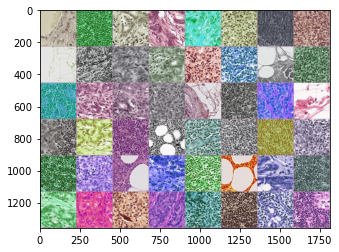

In [22]:
def visualize_batch(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = means_and_stds['channel_means']
    std = means_and_stds['channel_stds']
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
visualize_batch(out)

The hue and saturation augmentation we are performing is clearly very strong, as intended. We want to make sure that our model is robust to large changes in the color space, as variance exists within our dataset due to slides having been scanned in different places.

Let's define a classification model.

In [23]:
class_names = ['metastasis', 'non_metastasis']
model_ft = models.vgg19_bn(pretrained=True)
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs, len(class_names))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    model_ft = nn.DataParallel(model_ft)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer_ft, step_size=7, gamma=0.1)

We're now ready to establish a function to train a classification model.

In [24]:
def train_classification_model(model, criterion, optimizer, scheduler=False, num_epochs=30):
    best_model_state_dict = copy.deepcopy(model.state_dict())
    best_accuracy = 0.0
    learning_stats = {'train': [], 'val': []}
        
    for epoch in range(num_epochs):
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            epoch_ground_truth = []
            epoch_predictions = []
            running_loss = 0.0
        
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                      
                epoch_ground_truth = epoch_ground_truth + labels.data.tolist()
                epoch_predictions = epoch_predictions + preds.tolist()
                running_loss += loss.item() * inputs.size(0)
                
            if scheduler:
                if phase == 'train':
                    scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = accuracy_score(epoch_ground_truth, epoch_predictions)
            epoch_weighted_acc = balanced_accuracy_score(epoch_ground_truth, epoch_predictions)
            epoch_weighted_rec = recall_score(epoch_ground_truth, epoch_predictions, average='weighted')
            epoch_weighted_prec = precision_score(epoch_ground_truth, epoch_predictions, average='weighted')
            epoch_weighted_f1 = f1_score(epoch_ground_truth, epoch_predictions, average='weighted')
            
            learning_stats[phase].append(
                {'loss': epoch_loss, 
                 'accuracy': epoch_acc, 
                 'weighted_accuracy': epoch_weighted_acc,
                 'weighted_precision': epoch_weighted_prec,
                 'weighted_recall': epoch_weighted_rec,
                 'weighted_f1': epoch_weighted_f1})
            
            print('Phase Loss: {:.4f} Acc: {:.4f} Weighted Acc: {:.4f} Weighted Pre: {:.4f} Weighted Rec: {:.4f} Weighted F1: {:.4f}')
            print(phase, epoch_loss, epoch_acc, epoch_weighted_acc, epoch_weighted_prec, epoch_weighted_rec, epoch_weighted_f1)
     
            
            if (phase == 'val') and (epoch_acc > best_accuracy):
                best_accuracy = epoch_acc
                best_model_state_dict = copy.deepcopy(model.state_dict())
                  
    return best_model_state_dict, learning_stats

Let's call our function to train a classification model with desired hyperparameters and save the results. (34m 21s)

In [26]:
start_time = time.time()

model_ft, learningStats = train_classification_model(model_ft, criterion, optimizer_ft, scheduler=exp_lr_scheduler, num_epochs=30)

pickle.dump(learningStats, open(os.path.join(analysis_dir_path, 'classification_results', 
    'classification_learning_stats.p'), 'wb'))
torch.save(model_ft, os.path.join(analysis_dir_path, 'classification_results', 'classification_best_model_ft.pt'))

time_elapsed = time.time() - start_time
print('Complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

100%|██████████| 63/63 [00:11<00:00,  5.36it/s]


Let's plot some |of the training statistics to see how our model learned. If validation accuracy is substantially lower than training accuracy and/or validation loss is substantially higher than training loss, the model is overfitting, which would be a bad sign.

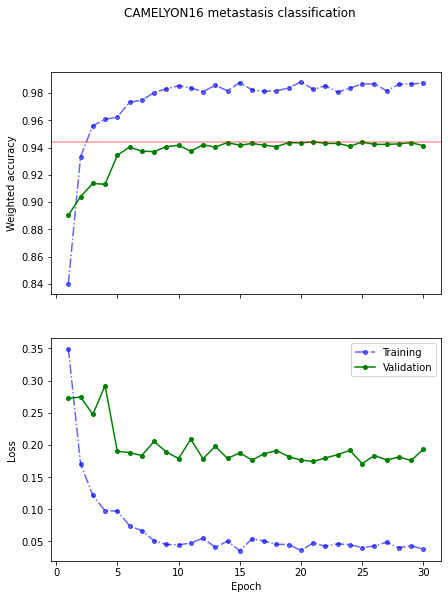

In [27]:
trainLoss = [epoch["loss"] for epoch in learningStats['train']]
valLoss = [epoch["loss"] for epoch in learningStats['val']]
trainAcc = [epoch["weighted_accuracy"] for epoch in learningStats['train']]
valAcc = [epoch["weighted_accuracy"] for epoch in learningStats['val']]
numEpochs = len(learningStats['train'])

fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('CAMELYON16 metastasis classification')
ax1.plot(np.arange(numEpochs)+1,trainAcc,'bo-.',label="Training",alpha=0.6,markersize=4)
ax1.plot(np.arange(numEpochs)+1,valAcc,'go-',label="Validation",markersize=4)
ax1.axhline(y=np.max(valAcc),color="r",alpha=0.4)
ax1.set(ylabel="Weighted accuracy")
ax1.label_outer()
ax2.plot(np.arange(numEpochs)+1,trainLoss,'bo-.',label="Training",alpha=0.6,markersize=4)
ax2.plot(np.arange(numEpochs)+1,valLoss,'go-',label="Validation",markersize=4)
ax2.set(xlabel="Epoch", ylabel="Loss")
fig.set_size_inches(7,9)
plt.legend()
plt.savefig(os.path.join(analysis_dir_path, 'classification_results', 'classification_learning_curves.png'))
plt.show(block=False)

We see that our accuracy tends to increase, both train and val, and our loss tends to decrease in the same way. This is good and means that training was successful. Note that for these accuracy scores, we binarize tiles as being in the metastasis class if they have have been assigned a probability greater than 0.5 for metastasis by the model. We will find the best such threshold to apply to our test set shortly.

Next, we're ready to infer our trained model on all the tissue foreground tiles in the test set and validation set. We infer on the validation set so that we can determine the best tile-level probability cutoff for deciding which tiles should be considered metastastatic by the model. We can then apply this threshold to the test set to measure our performance. PathML makes this easy with its inferClassifier() function. (13m 4s)

In [3]:
start_time = time.time()

class_names = ['metastasis', 'non_metastasis']
means_and_stds = pickle.load(open(os.path.join(analysis_dir_path, 'classification_results', 'trainval_channel_means_and_stds.p'), 'rb'))
modelPath = glob.glob(os.path.join(analysis_dir_path, 'classification_results', 'classification_best_model*'))[0]

dataTransforms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(means_and_stds['channel_means'], means_and_stds['channel_stds'])])

trainedModel = models.vgg19_bn(pretrained=False)
num_ftrs = trainedModel.classifier[6].in_features
trainedModel.classifier[6] = nn.Linear(num_ftrs, len(class_names))
trainedModel.load_state_dict(torch.load(modelPath))

for case in val_cases + test_cases:
    pathml_slide = Slide(os.path.join(analysis_dir_path, 'pathml_slides', case+'.pml'))
    pathml_slide.inferClassifier(trainedModel, classNames=class_names, dataTransforms=dataTransforms, tissueLevelThreshold=0.995, foregroundLevelThreshold=88)
    pathml_slide.save(folder=pathml_slide_dir_path)
    
time_elapsed = time.time() - start_time
print('Complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

  0%|          | 0/60 [00:00<?, ?it/s]

Inferring model on GPU


  0%|          | 0/152 [00:00<?, ?it/s]

Inferring model on GPU


  0%|          | 0/1014 [00:00<?, ?it/s]

Inferring model on GPU


  0%|          | 0/277 [00:00<?, ?it/s]

Inferring model on GPU


  0%|          | 0/93 [00:00<?, ?it/s]

Inferring model on GPU


  0%|          | 0/76 [00:00<?, ?it/s]

Inferring model on GPU


  0%|          | 0/60 [00:00<?, ?it/s]

Inferring model on GPU


  0%|          | 0/196 [00:00<?, ?it/s]

Inferring model on GPU


  0%|          | 0/137 [00:00<?, ?it/s]

Inferring model on GPU


  0%|          | 0/286 [00:00<?, ?it/s]

Inferring model on GPU


  0%|          | 0/109 [00:00<?, ?it/s]

Inferring model on GPU


  0%|          | 0/467 [00:00<?, ?it/s]

Inferring model on GPU


100%|██████████| 467/467 [01:59<00:00,  3.91it/s]


Complete in 13m 4s


Let's visualize the model's inference heatmap on our three tumor validation sets slide to confirm whether the model learned the right thing. PathML's visualizeClassifierInference() function does just that. (8m)

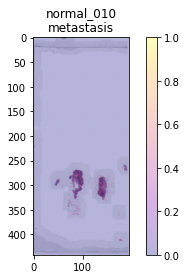

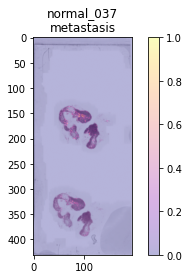

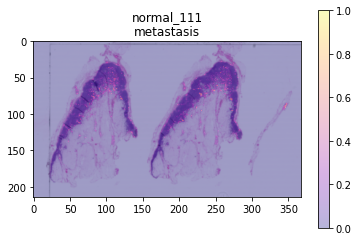

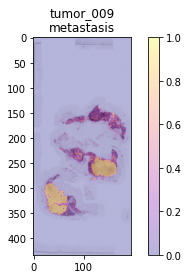

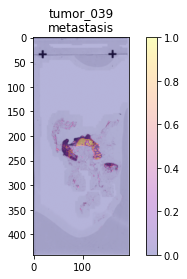

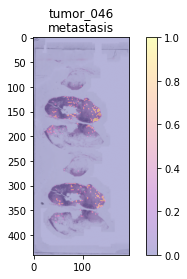

In [3]:
for case in val_cases:
    pathml_slide = Slide(os.path.join(analysis_dir_path, 'pathml_slides', case+'.pml'))
    pathml_slide.visualizeClassifierInference('metastasis', folder=os.path.join(analysis_dir_path, 'classification_results'))

If we now compare these with the actual images, we see that our model is working beautifully: the normal slides show little to no tiles that were assigned a high metastasis probability, and in the tumor slides, the regions in the inference maps showing high probability for metastasis are the metastases in the slides

Now that we know our model has high predictive accuracy and have confirmed with the inference map that the model learned the right thing, we can move on to checking the classification performance on the whole test set. There are two ways we can do this depending on our situations:

1. Assuming that we have ground truth annotations on the test set; or
2. Assuming that we do not have ground truth annotations on the test set

For our data, case 1 holds true, since we do have annotations for our test set, so we are able to get a tile-level accuracy on our test set. If, as is true in many situations where annotations are very costly to generate, the test set does not have annotations and instead only a slide-level ground truth (case 2), then we must develop a way to generalize our predictions from the tile-level to the slide level so that we can find a slide-level performance on the test set. We will show how to handle both cases in this tutorial.

Let's start by handling case 1. To get a tile-level accuracy for our test set, we first need to find a tile-level metastasis probability threshold above which we should consider a tile to have been called metastatic by the model. We can find this best threshold from our validation set using PathML's classifierMetricAtThreshold() function and then apply it to our test set to measure test set performance. (1m 52s)

In [6]:
probability_thresholds = np.append(np.arange(0, 1, 0.005),[0.9925, 0.995, 0.9975, 0.999, 0.99925, 0.9995, 0.99975, 0.9999, 0.999925, 0.99995, 0.999975, 0.99999, 0.9999925, 0.999995, 0.9999975, 0.999999]).tolist()
threshold_accuracies_all_slides = []

for val_case in val_cases:
    val_slide_path = os.path.join(analysis_dir_path, 'pathml_slides', val_case+'.pml')
    val_slide = Slide(val_slide_path)
    
    threshold_accuracies = val_slide.classifierMetricAtThreshold('metastasis', probability_thresholds, tileAnnotationOverlapThreshold=0.3, metric='accuracy', assignZeroToTilesWithoutAnnotationOverlap=True)
    threshold_accuracies_all_slides.append(threshold_accuracies)
    
threshold_avg_accuracies = np.mean(np.array(threshold_accuracies_all_slides), axis=0)
index_of_best_classification_threshold = np.argmax(threshold_avg_accuracies)
best_classification_threshold = probability_thresholds[index_of_best_classification_threshold]

print("Best tile-level validation accuracy:", threshold_avg_accuracies[index_of_best_classification_threshold])
print("Threshold that gives the best tile-level validation accuracy:", best_classification_threshold)

Best tile-level validation accuracy: 0.9497702868818131
Threshold that gives the best tile-level validation accuracy: 0.98


We see that a very high probability threshold provides us the best accuracy (0.98), which makes sense, because only keeping the most sure metastasis tiles will separate out negative cases from positive cases with only one very small metastasis area. Let's plot the accuracies of all the probability thresholds we checked.

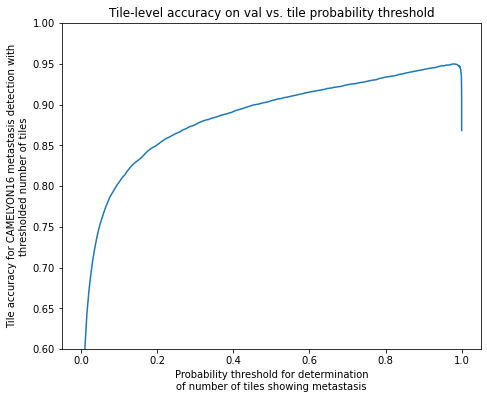

In [7]:
plt.figure(figsize=(7.5,6))
plt.plot(probability_thresholds, threshold_avg_accuracies)
plt.xlim(-0.05, 1.05)
plt.ylim(0.6, 1.0)
plt.title('Tile-level accuracy on val vs. tile probability threshold')
plt.xlabel('Probability threshold for determination\nof number of tiles showing metastasis')
plt.ylabel('Tile accuracy for CAMELYON16 metastasis detection with\nthresholded number of tiles')
plt.savefig(os.path.join(analysis_dir_path, 'classification_results', 'classification_validation_tile_accuracy_vs_probability_threshold.png'))
plt.show(block=False)

We see that as probability threshold increases, accuracy tends to as well, which confirms our hypothesis above.

Now that we have a best threshold and understand why it is sensible, we can use PathML's classifierMetricAtThreshold() on our test set to evaluate our model's performance by getting the accuracy at our threshold for each slide, and then averaging across slides. (8s)

In [12]:
test_accuracies_df_rows = []

for test_case in test_cases:
    test_slide_path = os.path.join(analysis_dir_path, 'pathml_slides', test_case+'.pml')
    test_slide = Slide(test_slide_path)
    test_accuracy = test_slide.classifierMetricAtThreshold('metastasis', best_classification_threshold, tileAnnotationOverlapThreshold=0.3, metric='accuracy', assignZeroToTilesWithoutAnnotationOverlap=True)
    test_accuracies_df_rows.append([test_case, test_accuracy])

test_accuracies_df = pd.DataFrame(test_accuracies_df_rows, columns=['Slide_ID', 'Metastasis accuracy (>'+str(round(best_classification_threshold, 6))+')'])
test_accuracies_df.to_csv(os.path.join(analysis_dir_path, 'classification_results', 'classification_test_accuracies_with_'+str(round(best_classification_threshold, 6))+'_df.csv'), index=False)

print("Average test set accuracy at metastasis probability threshold of "+str(best_classification_threshold)+":", test_accuracies_df['Metastasis accuracy (>'+str(round(best_classification_threshold, 6))+')'].mean())
print("Case-by-case test set accuracies:")
print(test_accuracies_df)

Average test set accuracy at metastasis probability threshold of 0.98: 0.9749579106360092
Case-by-case test set accuracies:
     Slide_ID  Metastasis accuracy (>0.98)
0  normal_028                     0.998328
1  normal_074                     0.983447
2  normal_141                     0.999267
3   tumor_036                     0.977095
4   tumor_058                     0.940234
5   tumor_076                     0.951376


So we see that we get a very good 97.5% tile-level accuracy on our test set. Our model clearly works.

Next, let's work out case 2, where we pretend that we don't have any annotations on our test set, which is a common situation in practice. How should we measure our model's performance on the test set in this case? To do so, we need to determine a way to generalize tile-level predictions to the slide level so that we can check performance against our slide-level test set labels. We can do this by using the number of tiles with metastasis probability above our best threshold as a way to generalize. Let's first get the number of tiles above our threshold for each test set slide using PathML's numTilesAboveClassPredictionThreshold() function. (2s)

In [15]:
test_tile_counts_df_rows = []

for test_case in test_cases:
    test_slide = Slide(os.path.join(analysis_dir_path, 'pathml_slides', test_case+'.pml'))
    num_metastasis_tiles_above_threshold = test_slide.numTilesAboveClassPredictionThreshold('metastasis', best_classification_threshold)

    if 'tumor' in test_case:
        metastasis_ground_truth = 1
    else:
        metastasis_ground_truth = 0

    test_tile_counts_df_rows.append([test_case, metastasis_ground_truth, num_metastasis_tiles_above_threshold])
    
test_tile_counts_df = pd.DataFrame(test_tile_counts_df_rows, columns=['Slide_ID', 'Metastasis_ground_truth', 'Metastasis tile count (>'+str(round(best_classification_threshold, 6))+')'])
test_tile_counts_df.to_csv(os.path.join(analysis_dir_path, 'classification_results', 'classification_test_tile_counts_above_'+str(round(best_classification_threshold, 6))+'_df.csv'), index=False)

print(test_tile_counts_df)

     Slide_ID  Metastasis_ground_truth  Metastasis tile count (>0.98)
0  normal_028                        0                              3
1  normal_074                        0                             97
2  normal_141                        0                              3
3   tumor_036                        1                             51
4   tumor_058                        1                            589
5   tumor_076                        1                           8863


We see that there is a difference in the number of tiles above our best threshold between the normal slides and tumor slides, as expected. Let's compute an AUC from these data, comparing metastasis ground truth to the number of metastasis tiles above our best threshold. Although it's a bit silly to consider an AUC with only 6 rows of data, in practice, a test set would likely have more patients.

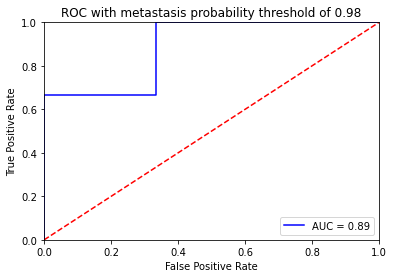

In [16]:
testAuc = roc_auc_score(test_tile_counts_df['Metastasis_ground_truth'], 
    test_tile_counts_df['Metastasis tile count (>'+str(round(best_classification_threshold, 6))+')'])
fpr, tpr, thresholds = roc_curve(test_tile_counts_df['Metastasis_ground_truth'], 
    test_tile_counts_df['Metastasis tile count (>'+str(round(best_classification_threshold, 6))+')'])

plt.figure()
plt.title('ROC with metastasis probability threshold of '+str(round(best_classification_threshold, 6)))
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % testAuc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig(os.path.join(analysis_dir_path, 'classification_results', 'classification_test_auc_roc.png'))
plt.show(block=False)

Since there is a metastasis tile count decision boundary above which all cases are ground truth positive (tumor slides), we get a perfect AUC.

Now that we've finished evaluating our classification model, let's train a segmentation model from the masks we extracted earlier. Begin by initializing a segmentation model architecture, moving it to the GPU, defining a loss function, optimizer, and learning rate scheduler (if desired), as well as training and validation data transforms for data augmentation. Use the Albumentations library to define the augmentations so that they can be performed in parallel between a tile image and its corresponding mask.

In [3]:
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f'Using device {device}')

net = UNet(n_channels=3, n_classes=1, bilinear=True)
logging.info(f'Network:\n'
             f'\t{net.n_channels} input channels\n'
             f'\t{net.n_classes} output channels (classes)\n'
             f'\t{"Bilinear" if net.bilinear else "Transposed conv"} upscaling')
net.to(device=device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9) 

# Establish training and validation data augmentations. 
# We are introducing strong HSV color jittering to account 
# for the different labs the images were scanned at
# We are using the Albumentations library here to support
# smart image/mask parallel augmentation
# Note that normalizing from 0-255 to 0-1 is already done for us by 
# PathmlSegmentationDataset, and we don't need to normalize to ImageNet
# either since we are training from scratch. Our function already turns
# the image and mask into tensors for us. So we don't need to include
# an equivalent to torchvision's transforms.Normalize() or ToTensor()
train_transform = A.Compose([
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.ColorJitter(brightness=0, contrast=0, saturation=0.1, hue=.05),
])
val_transform = None

INFO: Using device cuda
INFO: Network:
	3 input channels
	1 output channels (classes)
	Bilinear upscaling


Let's check to make sure that our augmentations look reasonable are going to work in parallel between our image and our mask. We'll visualize our augmentation using visualizeSegmentationAugmentation() on an example tile and matching mask from our validation slide tumor_009:

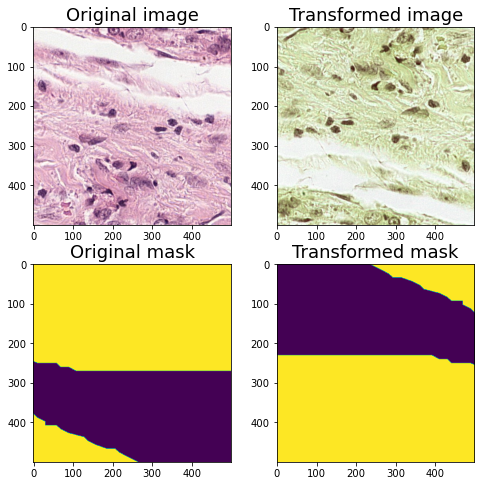

In [26]:
example_tiles = glob.glob(os.path.join(analysis_dir_path, 'tiles', 'tumor_009', 'metastasis', '*.jpg'))
example_masks = glob.glob(os.path.join(analysis_dir_path, 'masks', 'tumor_009', 'metastasis', '*.gif'))
example_tiles.sort()
example_masks.sort()
tile_to_visualize_idx = random.randrange(len(example_tiles))

train_transform_no_normalize = A.Compose([
    A.VerticalFlip(p=1),
    A.HorizontalFlip(p=1),
    A.ColorJitter(brightness=0, contrast=0, saturation=1, hue=0.5),
])

visualizeSegmentationAugmentation(path_to_image=example_tiles[tile_to_visualize_idx], path_to_mask=example_masks[tile_to_visualize_idx], transform=train_transform_no_normalize)

We see that with the help of albumentations, our image and mask are spatially augmented in parallel, whereas things like color augmentations are applied only to the image, as desired.

Next, let's make a function to train a U-Net segmentation model. Note that all of the following segmentation code modified code from the following open-source implementation of U-Net in Pytorch: https://github.com/milesial/Pytorch-UNet. Also note that we've made and use a custom Pytorch-compatible dataset, PathmlSegmentationDataset (based on the open-source code above), that works with the directory structure PathML outputs its images and masks in.

In [4]:
def train_segmentation_model(net, dir_img, dir_mask, train_ids, val_ids, device, 
                               criterion, optimizer, scheduler=None, epochs=30, batch_size=3, 
                               mask_suffix='_mask', train_transform=None, val_transform=None):
    
    train_dataset = PathmlSegmentationDataset(imgs_dir=dir_img, masks_dir=dir_mask, ids_to_use=train_ids, 
                                              mask_suffix=mask_suffix, transform=train_transform)
    val_dataset = PathmlSegmentationDataset(imgs_dir=dir_img, masks_dir=dir_mask, ids_to_use=val_ids, 
                                            mask_suffix=mask_suffix, transform=val_transform)
    n_val = len(val_dataset)
    n_train = len(train_dataset)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True, 
                            drop_last=True)
    best_val_dice = 0
    segmentation_learning_stats = {'train': [], 'val': []}

    logging.info(f'''Starting training:
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {optimizer.param_groups[0]['lr']}
        Training size:   {n_train}
        Validation size: {n_val}
        Device:          {device.type}
    ''')

    for epoch in range(epochs):
        net.train()

        epoch_train_loss = 0
        epoch_train_dice = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch + 1}/{epochs}', unit='img') as pbar:
            for batch in train_loader:
                imgs = batch['image']
                true_masks = batch['mask']
                assert imgs.shape[1] == net.n_channels, \
                    f'Network has been defined with {net.n_channels} input channels, ' \
                    f'but loaded images have {imgs.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

                imgs = imgs.to(device=device, dtype=torch.float32)
                mask_type = torch.float32 if net.n_classes == 1 else torch.long
                true_masks = true_masks.to(device=device, dtype=mask_type)

                masks_pred = net(imgs)
                loss = criterion(masks_pred, true_masks)
                epoch_train_loss += loss.item()
                
                pred = torch.sigmoid(masks_pred)
                pred = (pred > 0.5).float()
                epoch_train_dice += dice_coeff(pred, true_masks).item()

                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_value_(net.parameters(), 0.1)
                optimizer.step()

                pbar.update(imgs.shape[0])
        
        train_dice = epoch_train_dice / len(train_loader)
        train_loss = epoch_train_loss / len(train_loader)
        # check performance on validation set
        val_dice, val_loss = eval_net(net, val_loader, criterion, device)
        
        segmentation_learning_stats['train'].append(
            {'loss': train_loss, 
             'dice_coeff': train_dice, 
             'learning_rate': optimizer.param_groups[0]['lr']})
        segmentation_learning_stats['val'].append(
            {'loss': val_loss, 
             'dice_coeff': val_dice, 
             'learning_rate': optimizer.param_groups[0]['lr']})

        logging.info('Training Dice Coeff: {}'.format(train_dice))
        logging.info('Training Loss: {}'.format(train_loss))
        logging.info('Validation Dice Coeff: {}'.format(val_dice))
        logging.info('Validation Loss: {}'.format(val_loss))
        logging.info('Learning rate: {}'.format(optimizer.param_groups[0]['lr']))
        
        if scheduler is not None:
            scheduler.step()
            
        # deep copy the model if it shows the best validation performance
        if val_dice > best_val_dice:
            best_val_dice = val_dice
            best_model_state_dict = copy.deepcopy(net.state_dict())
    
    return best_model_state_dict, segmentation_learning_stats

Let's now run our U-Net model on our training and validation data, saving the resulting learning statistics and trained model to our segmentation_results directory. (186m 53s)

In [5]:
start_time = time.time()

dir_img = os.path.join(analysis_dir_path, 'tiles')
dir_mask = os.path.join(analysis_dir_path, 'masks')
dir_results = os.path.join(analysis_dir_path, 'segmentation_results')

# Train model
model_ft, segmentation_learning_stats = train_segmentation_model(net=net, dir_img=dir_img, dir_mask=dir_mask, 
                                                   train_ids=train_cases, val_ids=val_cases, 
                                                   criterion=criterion, optimizer=optimizer, scheduler=scheduler, 
                                                   epochs=30, batch_size=6, device=device, 
                                                   train_transform=train_transform, val_transform=val_transform)

pickle.dump(segmentation_learning_stats, open(os.path.join(dir_results, 'segmentation_learning_stats.p'), 'wb'))
torch.save(model_ft, os.path.join(dir_results, 'segmentation_best_model_ft.pt'))

time_elapsed = time.time() - start_time
print('Complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

INFO: Creating dataset with 3000 examples
INFO: Creating dataset with 3000 examples
INFO: Starting training:
        Epochs:          30
        Batch size:      6
        Learning rate:   0.0001
        Training size:   3000
        Validation size: 3000
        Device:          cuda
    
Epoch 1/30: 100%|██████████| 3000/3000 [04:36<00:00, 10.85img/s]
INFO: Training Dice Coeff: 0.4261796139079722                         
INFO: Training Loss: 0.5280227288901805
INFO: Validation Dice Coeff: 0.5013336478584185
INFO: Validation Loss: 0.44970621775090697
INFO: Learning rate: 0.0001
INFO: Checkpoint 1 saved !
Epoch 2/30: 100%|██████████| 3000/3000 [05:13<00:00,  9.58img/s]
INFO: Training Dice Coeff: 0.4956787809306996                         
INFO: Training Loss: 0.4617801909148693
INFO: Validation Dice Coeff: 0.5447451967669128
INFO: Validation Loss: 0.48904420795291664
INFO: Learning rate: 9e-05
INFO: Checkpoint 2 saved !
Epoch 3/30: 100%|██████████| 3000/3000 [05:13<00:00,  9.57img/s]
I

INFO: Learning rate: 7.976644307687257e-06
Epoch 26/30: 100%|██████████| 3000/3000 [04:53<00:00, 10.23img/s]
INFO: Training Dice Coeff: 0.7345589682459831                         
INFO: Training Loss: 0.18854865793883802
INFO: Validation Dice Coeff: 0.7361190918385982
INFO: Validation Loss: 0.2757715649306774
INFO: Learning rate: 7.1789798769185315e-06
Epoch 27/30: 100%|██████████| 3000/3000 [04:53<00:00, 10.22img/s]
INFO: Training Dice Coeff: 0.7380366295092693                         
INFO: Training Loss: 0.19061126037314535
INFO: Validation Dice Coeff: 0.7135114374235996
INFO: Validation Loss: 0.2939012352563441
INFO: Learning rate: 6.461081889226678e-06
Epoch 28/30: 100%|██████████| 3000/3000 [04:53<00:00, 10.23img/s]
INFO: Training Dice Coeff: 0.7378445951056879                         
INFO: Training Loss: 0.18985054401680826
INFO: Validation Dice Coeff: 0.7407168589932535
INFO: Validation Loss: 0.291300466299057
INFO: Learning rate: 5.81497370030401e-06
Epoch 29/30: 100%|███████

NameError: name 'now' is not defined

Let's again plot some of the training statistics to see how our model learned. We will use the Dice coefficient in the same way we used accuracy in the classification model. If validation Dice score is substantially lower than training Dice score and/or validation loss is substantially higher than training loss, the model is overfitting, which would be a bad sign.

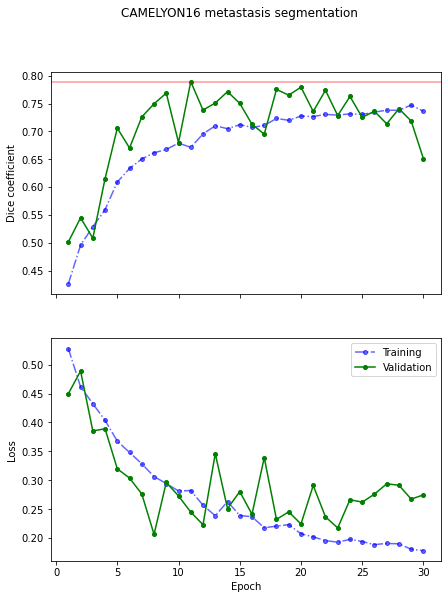

In [12]:
segmentationLearningStats = pickle.load(open(glob.glob(os.path.join(analysis_dir_path, 'segmentation_results', 'segmentation_learning_stats*'))[0], "rb"))
trainLoss = [epoch["loss"] for epoch in segmentationLearningStats['train']]
valLoss = [epoch["loss"] for epoch in segmentationLearningStats['val']]
trainDice = [epoch["dice_coeff"] for epoch in segmentationLearningStats['train']]
valDice = [epoch["dice_coeff"] for epoch in segmentationLearningStats['val']]
numEpochs = len(segmentationLearningStats['train'])

fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('CAMELYON16 metastasis segmentation')
ax1.plot(np.arange(numEpochs)+1,trainDice,'bo-.',label="Training",alpha=0.6,markersize=4)
ax1.plot(np.arange(numEpochs)+1,valDice,'go-',label="Validation",markersize=4)
ax1.axhline(y=np.max(valDice),color="r",alpha=0.4)
ax1.set(ylabel="Dice coefficient")
ax1.label_outer()
ax2.plot(np.arange(numEpochs)+1,trainLoss,'bo-.',label="Training",alpha=0.6,markersize=4)
ax2.plot(np.arange(numEpochs)+1,valLoss,'go-',label="Validation",markersize=4)
ax2.set(xlabel="Epoch", ylabel="Loss")
fig.set_size_inches(7,9)
plt.legend()
plt.savefig(os.path.join(analysis_dir_path, 'segmentation_results', 'segmentation_learning_curves.png'))
plt.show(block=False)

We see that our Dice score tends to increase, both train and val, and our loss tends to decrease in the same way. This is good and means that training was successful. Note that for these Dice scores, we binarize pixels as being in the metastasis class if they have have been assigned a probability greater than 0.5 for metastasis by the model.

Next, we're ready to infer our trained model on all the tissue foreground tiles in the validation set and test set. We infer on the validation set so that we can select the best probability cutoff to determine whether a pixel is metastasis or not that we can then apply to the test set. We will then evaluate the Dice score of the test set at that cutoff to see how our model performs on the test set. PathML makes this easy with its inferSegmentor() function. (50min. 53 sec.)

In [20]:
start_time = time.time()

segmentation_model_path = glob.glob(os.path.join(analysis_dir_path, 'segmentation_results', 'segmentation_best_model*'))[0]

segmentation_class_names = ['metastasis']
trained_model = UNet(n_channels=3, n_classes=len(segmentation_class_names))
trained_model.load_state_dict(torch.load(segmentation_model_path, map_location=device))

for case in val_cases + test_cases:
    pathml_slide = Slide(os.path.join(analysis_dir_path, 'pathml_slides', case+'.pml'))
    pathml_slide.inferSegmenter(trained_model, classNames=segmentation_class_names, batchSize=3, foregroundLevelThreshold=70, tissueLevelThreshold=0.999, dtype='int')
    pathml_slide.save(folder=pathml_slide_dir_path)
    
time_elapsed = time.time() - start_time
print('Complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

  0%|          | 0/592 [00:00<?, ?it/s]

Inferring model on GPU


  0%|          | 0/1516 [00:00<?, ?it/s]

Inferring model on GPU


  0%|          | 0/10136 [00:00<?, ?it/s]

Inferring model on GPU


  0%|          | 0/2768 [00:00<?, ?it/s]

Inferring model on GPU


  0%|          | 0/924 [00:00<?, ?it/s]

Inferring model on GPU


  0%|          | 0/754 [00:00<?, ?it/s]

Inferring model on GPU


  0%|          | 0/598 [00:00<?, ?it/s]

Inferring model on GPU


  0%|          | 0/1954 [00:00<?, ?it/s]

Inferring model on GPU


  0%|          | 0/1365 [00:00<?, ?it/s]

Inferring model on GPU


  0%|          | 0/2853 [00:00<?, ?it/s]

Inferring model on GPU


  0%|          | 0/1082 [00:00<?, ?it/s]

Inferring model on GPU


  0%|          | 0/4662 [00:00<?, ?it/s]

Inferring model on GPU


100%|██████████| 4662/4662 [07:33<00:00, 10.28it/s]


Complete in 50m 53s


Let's visualize the model's inference heatmap on our three tumor validation sets slide to confirm whether the model learned the right thing. PathML's visualizeSegmenterInference() function does just that. (7 min.)

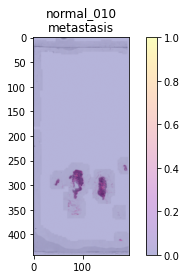

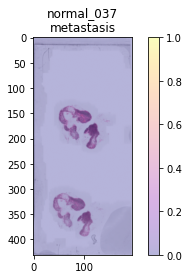

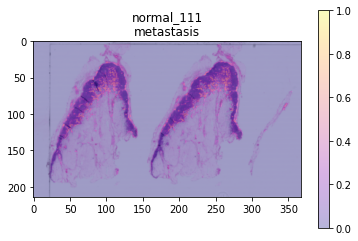

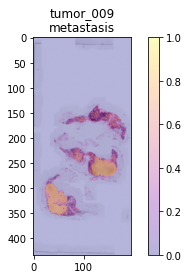

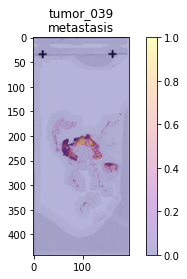

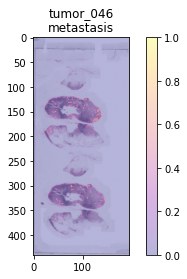

In [4]:
for case in val_cases:
    pathml_slide = Slide(os.path.join(analysis_dir_path, 'pathml_slides', case+'.pml'))
    pathml_slide.visualizeSegmenterInference('metastasis', folder=os.path.join(analysis_dir_path, 'segmentation_results'))

We see that much like our classification inference visualizations above, our segmentation model appears to be locating the tumor regions in our slide pretty accurately.

Now that we've inferred our trained segmentation model on all of our validation and test slides, we need to find the best pixel probability threshold for metastasis to maximize our validation Dice scores, so that we can then apply that threshold to our test set to get our final test set performance. We can do this with PathML's segmenterMetricAtThreshold() function. (17 hr. 47 min.)

In [5]:
start_time = time.time()

probability_thresholds = np.append(np.append(np.arange(0.05, 0.90, 0.05), 
                                   np.arange(0.86, 0.991, 0.01)), 
                                   np.arange(0.991, 1, 0.001)).tolist()
threshold_dice_scores_all_slides = {}

for val_case in val_cases:
    val_slide_path = os.path.join(analysis_dir_path, 'pathml_slides', val_case+'.pml')
    val_slide = Slide(val_slide_path)

    threshold_dice_scores = val_slide.segmenterMetricAtThreshold('metastasis', probability_thresholds, metric='dice_coeff')
    threshold_dice_scores_all_slides[val_case] = threshold_dice_scores

pickle.dump(threshold_dice_scores_all_slides[val_case],
    open(os.path.join(analysis_dir_path, 'segmentation_results', 'val_dice_scores_at_thresholds.p'), 'wb'))

# Find the threshold-wise mean of each Slide's Dice scores
threshold_avg_dice_scores = np.mean(np.array(list(threshold_dice_scores_all_slides.values())), axis=0)

# Find the threshold with the highest accuracy
index_of_best_segmentation_threshold = np.argmax(threshold_avg_dice_scores)
best_segmentation_threshold = probability_thresholds[index_of_best_segmentation_threshold]

print("Best tile-level validation Dice score:", threshold_avg_dice_scores[index_of_best_segmentation_threshold])
print("Threshold that gives the best tile-level validation Dice score:", best_segmentation_threshold)

time_elapsed = time.time() - start_time
print('Complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Mean Dice score at threshold 0.05: 1.3323210595201439e-06
Mean Dice score at threshold 0.1: 0.04859401323792547
Mean Dice score at threshold 0.15000000000000002: 0.46822938821788745
Mean Dice score at threshold 0.2: 0.61799167712611
Mean Dice score at threshold 0.25: 0.6925094197642364
Mean Dice score at threshold 0.3: 0.7555765354405504
Mean Dice score at threshold 0.35000000000000003: 0.8004938177271228
Mean Dice score at threshold 0.4: 0.833998626816112
Mean Dice score at threshold 0.45: 0.8565486437384131
Mean Dice score at threshold 0.5: 0.8760716986344351
Mean Dice score at threshold 0.55: 0.8959059874538622
Mean Dice score at threshold 0.6000000000000001: 0.9164865218757168
Mean Dice score at threshold 0.6500000000000001: 0.9333612564131457
Mean Dice score at threshold 0.7000000000000001: 0.9485494183528107
Mean Dice score at threshold 0.7500000000000001: 0.9613757041314825
Mean Dice score at threshold 0.8: 0.9732606388619821
Mean Dice score at threshold 0.8500000000000001: 0.98

Mean Dice score at threshold 0.86: 0.7783375595893588
Mean Dice score at threshold 0.87: 0.7768208302538279
Mean Dice score at threshold 0.88: 0.7720154272248182
Mean Dice score at threshold 0.89: 0.7664165667672764
Mean Dice score at threshold 0.9: 0.7529929749238583
Mean Dice score at threshold 0.91: 0.732580272124855
Mean Dice score at threshold 0.92: 0.7150950770981142
Mean Dice score at threshold 0.93: 0.684326873091999
Mean Dice score at threshold 0.9400000000000001: 0.6623195795832278
Mean Dice score at threshold 0.9500000000000001: 0.6318028823187872
Mean Dice score at threshold 0.9600000000000001: 0.6156662564529136
Mean Dice score at threshold 0.9700000000000001: 0.6014795130741079
Mean Dice score at threshold 0.9800000000000001: 0.5981035070678724
Mean Dice score at threshold 0.9900000000000001: 0.5972512910336703
Mean Dice score at threshold 0.991: 0.5972512910336703
Mean Dice score at threshold 0.992: 0.5972512910336703
Mean Dice score at threshold 0.993: 0.597247699674192

We see that a very high probability threshold (0.91) provides us the best accuracy, which makes sense, because only keeping the most sure metastasis tiles will separate out negative cases from positive cases with only one very small metastasis area. Let's plot the accuracies of all the probability thresholds we checked.

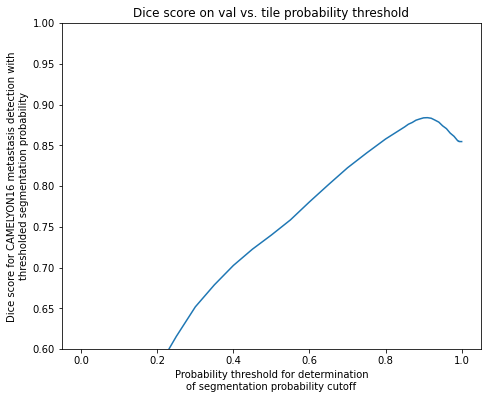

In [6]:
plt.figure(figsize=(7.5,6))
plt.plot(probability_thresholds, threshold_avg_dice_scores)
plt.xlim(-0.05, 1.05)
plt.ylim(0.6, 1.0)
plt.title('Dice score on val vs. tile probability threshold')
plt.xlabel('Probability threshold for determination\nof segmentation probability cutoff')
plt.ylabel('Dice score for CAMELYON16 metastasis detection with\nthresholded segmentation probability')
plt.savefig(os.path.join(analysis_dir_path, 'segmentation_results', 'segmentation_validation_dice_score_vs_probability_threshold.png'))
plt.show(block=False)

We see that similar to the classification threshold, as probability threshold increases, Dice score performance tends to as well, meaning that we should use a high probability threshold to maximize our test set performance.

Now that we have a best threshold, we can use PathML's same segmenterMetricAtThreshold() function on our test set to evaluate our model's performance by getting the test set Dice score at our threshold for each slide, and then averaging across slides. (34m 51s)

In [7]:
start_time = time.time()

test_dice_scores = []
test_dice_score_df_rows = []

for test_case in test_cases:
    test_slide_path = os.path.join(analysis_dir_path, 'pathml_slides', test_case+'.pml')
    test_slide = Slide(test_slide_path)
    test_dice_score = test_slide.segmenterMetricAtThreshold('metastasis', best_segmentation_threshold, metric='dice_coeff')
    test_dice_scores.append(test_dice_score)
    test_dice_score_df_rows.append([test_case, test_dice_score])
    
test_dice_score_df = pd.DataFrame(test_dice_score_df_rows, columns=['Slide_ID', 'Metastasis Dice score (>'+str(round(best_segmentation_threshold, 6))+')'])
test_dice_score_df.to_csv(os.path.join(analysis_dir_path, 'segmentation_results', 'segmentation_test_dice_score_above_'+str(round(best_segmentation_threshold, 6))+'_df.csv'), index=False)

print("Average test set Dice score at metastasis probability threshold of "+str(best_segmentation_threshold)+":", 
      np.mean(test_dice_scores))
print("Full results:")
print(test_dice_score_df)

time_elapsed = time.time() - start_time
print('Complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Mean Dice score at threshold 0.91: 0.9901673682688121
Mean Dice score at threshold 0.91: 0.8922816714786435
Mean Dice score at threshold 0.91: 0.9686535006281194
Mean Dice score at threshold 0.91: 0.9492883958764919
Mean Dice score at threshold 0.91: 0.8518067212778353
Mean Dice score at threshold 0.91: 0.34235905930372634
Average test set Dice score at metastasis probability threshold of 0.91: 0.8324261194722715
Full results:
     Slide_ID  Metastasis Dice score (>0.91)
0  normal_028                       0.990167
1  normal_074                       0.892282
2  normal_141                       0.968654
3   tumor_036                       0.949288
4   tumor_058                       0.851807
5   tumor_076                       0.342359
Complete in 21m 20s


We get an average Dice score of 0.89 across our test set using our best threshold from the validation set.

Some users may also want to save the entire pixel inference mask for the Slides they have inferred on. PathML's getNonOverlappingSegmentationInferenceArray() does this. If tile overlap is present in the tile dictionary, getNonOverlappingSegmentationInferenceArray() will automatically average the inference predictions at every pixel that overlaps more than one tile to produce a 2D pixel mask that is the same pixel dimensions as the WSI that was inferred on. Note that getNonOverlappingSegmentationInferenceArray() saves a .npz file containing a SciPy csr sparse matrix containing the pixel mask. If the dtype argument is left as the default ('int'), then the resulting pixel mask will contain numpy.uint8 values from 0 to 255. This is recommended to keep the .npz file small. If more precision is needed, set dtype to 'float' to get a pixel mask of numpy.float32 values from 0 to 1. Let's save a full inference mask for each of our test set Slides. (39 min.)

In [ ]:
for case in test_cases:
    pathml_slide = Slide(os.path.join(analysis_dir_path, 'pathml_slides', case+'.pml'))
    pathml_slide.getNonOverlappingSegmentationInferenceArray('metastasis', folder=os.path.join(analysis_dir_path, 'segmentation_results'))

Number of tiles merged: 1
Number of tiles merged: 2
Number of tiles merged: 3
Number of tiles merged: 4
Number of tiles merged: 5
Number of tiles merged: 6
Number of tiles merged: 7
Number of tiles merged: 8
Number of tiles merged: 9
Number of tiles merged: 10
Number of tiles merged: 11
Number of tiles merged: 12
Number of tiles merged: 13
Number of tiles merged: 14
Number of tiles merged: 15
Number of tiles merged: 16
Number of tiles merged: 17
Number of tiles merged: 18
Number of tiles merged: 19
Number of tiles merged: 20
Number of tiles merged: 21
Number of tiles merged: 22
Number of tiles merged: 23
Number of tiles merged: 24
Number of tiles merged: 25
Number of tiles merged: 26
Number of tiles merged: 27
Number of tiles merged: 28
Number of tiles merged: 29
Number of tiles merged: 30
Number of tiles merged: 31
Number of tiles merged: 32
Number of tiles merged: 33
Number of tiles merged: 34
Number of tiles merged: 35
Number of tiles merged: 36
Number of tiles merged: 37
Number of 

Number of tiles merged: 300
Number of tiles merged: 301
Number of tiles merged: 302
Number of tiles merged: 303
Number of tiles merged: 304
Number of tiles merged: 305
Number of tiles merged: 306
Number of tiles merged: 307
Number of tiles merged: 308
Number of tiles merged: 309
Number of tiles merged: 310
Number of tiles merged: 311
Number of tiles merged: 312
Number of tiles merged: 313
Number of tiles merged: 314
Number of tiles merged: 315
Number of tiles merged: 316
Number of tiles merged: 317
Number of tiles merged: 318
Number of tiles merged: 319
Number of tiles merged: 320
Number of tiles merged: 321
Number of tiles merged: 322
Number of tiles merged: 323
Number of tiles merged: 324
Number of tiles merged: 325
Number of tiles merged: 326
Number of tiles merged: 327
Number of tiles merged: 328
Number of tiles merged: 329
Number of tiles merged: 330
Number of tiles merged: 331
Number of tiles merged: 332
Number of tiles merged: 333
Number of tiles merged: 334
Number of tiles merg

Number of tiles merged: 594
Number of tiles merged: 595
Number of tiles merged: 596
Number of tiles merged: 597
Number of tiles merged: 598
Number of tiles merged: 599
Number of tiles merged: 600
Number of tiles merged: 601
Number of tiles merged: 602
Number of tiles merged: 603
Number of tiles merged: 604
Number of tiles merged: 605
Number of tiles merged: 606
Number of tiles merged: 607
Number of tiles merged: 608
Number of tiles merged: 609
Number of tiles merged: 610
Number of tiles merged: 611
Number of tiles merged: 612
Number of tiles merged: 613
Number of tiles merged: 614
Number of tiles merged: 615
Number of tiles merged: 616
Number of tiles merged: 617
Number of tiles merged: 618
Number of tiles merged: 619
Number of tiles merged: 620
Number of tiles merged: 621
Number of tiles merged: 622
Number of tiles merged: 623
Number of tiles merged: 624
Number of tiles merged: 625
Number of tiles merged: 626
Number of tiles merged: 627
Number of tiles merged: 628
Number of tiles merg

Number of tiles merged: 887
Number of tiles merged: 888
Number of tiles merged: 889
Number of tiles merged: 890
Number of tiles merged: 891
Number of tiles merged: 892
Number of tiles merged: 893
Number of tiles merged: 894
Number of tiles merged: 895
Number of tiles merged: 896
Number of tiles merged: 897
Number of tiles merged: 898
Number of tiles merged: 899
Number of tiles merged: 900
Number of tiles merged: 901
Number of tiles merged: 902
Number of tiles merged: 903
Number of tiles merged: 904
Number of tiles merged: 905
Number of tiles merged: 906
Number of tiles merged: 907
Number of tiles merged: 908
Number of tiles merged: 909
Number of tiles merged: 910
Number of tiles merged: 911
Number of tiles merged: 912
Number of tiles merged: 913
Number of tiles merged: 914
Number of tiles merged: 915
Number of tiles merged: 916
Number of tiles merged: 917
